# Posture Classification Training with ResNet18

## Imports and Configurations

### Imports

In [ ]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from tqdm import tqdm
from pathlib import Path
import kagglehub
import shutil
import numpy as np
from sklearn.metrics import precision_score, recall_score, confusion_matrix
from PIL import Image
from torchvision import transforms
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### Check CUDA Availability

In [2]:
if cuda_available:= torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

device = 'cuda' if cuda_available else 'cpu'
print(f"CUDA Available: {cuda_available}")

GPU: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA Available: True


### Global Variables

In [ ]:
CLASSES = ['sitting', 'standing']
NUM_CLASSES = len(CLASSES)
IMG_SIZE = 256

WEIGHTS_DIR = Path("../../runs/posture_classification/")
WEIGHTS_DIR.mkdir(parents=True, exist_ok=True)
BATCH_SIZE = 32

## Data Preparation

### Download Dataset

In [ ]:
kaggle_dataset_path = kagglehub.dataset_download("mexwell/silhouettes-for-human-posture-recognition")
src = Path(kaggle_dataset_path)
DATASET_DIR = Path("../../datasets/posture_classification")
DATASET_DIR.mkdir(parents=True, exist_ok=True)  # ensure target exists
for cls in CLASSES:
    src_cls = src / cls
    dst_cls = DATASET_DIR / cls
    if src_cls.exists():
        shutil.move(str(src_cls), str(dst_cls))

### Dataset Transformers

In [5]:
train_transforms = transforms.Compose([ 
    transforms.RandomResizedCrop( 
        IMG_SIZE, 
        scale=(0.85, 1.0), 
        ratio=(0.9, 1.1)
    ), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply(
        [ transforms.GaussianBlur(kernel_size=3) ], 
        p=0.15
    ), 
    transforms.RandomAffine( 
        degrees=10, 
        translate=(0.05, 0.05), 
        scale=(0.95, 1.05) 
    ), 
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(), 
    transforms.Normalize( 
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225] 
    ) 
]) 
val_transforms = transforms.Compose([ 
    transforms.Resize((IMG_SIZE, IMG_SIZE)), 
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(), 
    transforms.Normalize( 
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225] 
    ) 
])

### Dataset Split and Loaders

In [6]:
full_dataset = datasets.ImageFolder(
    root=DATASET_DIR,
    transform=train_transforms
)

# Train / Val split (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = val_transforms

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))

Train samples: 1920
Val samples: 480


## Training

### Load ResNet-18 Base Model

In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
DEVICE = torch.device(device)
model = model.to(DEVICE)

# Replace classifier head
model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)

### Helper Functions

In [ ]:
history = {
    "train_loss": [],
    "val_loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "confusion_matrices": [],
}

def plot_classification_training_results( history: dict, class_names=("sitting", "standing"), 
                                         save_path="results/posture_training_results.png" ):
    epochs = range(1, len(history["val_loss"]) + 1)
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    # ---- Loss ----
    axes[0, 0].plot(epochs, history["train_loss"], label="train")
    axes[0, 0].plot(epochs, history["val_loss"], label="val")
    axes[0, 0].set_title("Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # ---- Accuracy ----
    axes[0, 1].plot(epochs, history["accuracy"])
    axes[0, 1].set_title("Accuracy")
    axes[0, 1].grid(True)

    # ---- Precision ----
    axes[0, 2].plot(epochs, history["precision"])
    axes[0, 2].set_title("Precision")
    axes[0, 2].grid(True)

    # ---- Recall ----
    axes[1, 0].plot(epochs, history["recall"])
    axes[1, 0].set_title("Recall")
    axes[1, 0].grid(True)

    # ---- Confusion Matrix (last epoch) ----
    cm = history["confusion_matrices"][-1]
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        ax=axes[1, 1],
    )
    axes[1, 1].set_title("Confusion Matrix (Final Epoch)")
    axes[1, 1].set_xlabel("Predicted")
    axes[1, 1].set_ylabel("True")

    # Empty last subplot
    axes[1, 2].axis("off")

    plt.tight_layout()
    save_path = Path(save_path)
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=200)
    plt.close()

    print(f"Training results saved to {save_path}")
    return Image.open(save_path)
    

def validate(model, loader, criterion, device):
    model.eval()

    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    accuracy = (all_preds == all_labels).mean()
    precision = precision_score(all_labels, all_preds, average="binary")
    recall = recall_score(all_labels, all_preds, average="binary")
    cm = confusion_matrix(all_labels, all_preds)
    return {
        "loss": running_loss / len(loader),
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "confusion_matrix": cm
    }

### Initial Training

In [9]:
# Training params
EPOCHS = 25
LR = 3e-4
BEST_MODEL_NAME = "resnet18_posture_classification_best.pth"
FINAL_MODEL_NAME = "resnet18_posture_classification_initial.pth"

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

for param in model.parameters():
    param.requires_grad = False

for param in model.fc.parameters():
    param.requires_grad = True

best_val_acc = 0.0
for epoch in range(EPOCHS):
    model.train()
    start = time.time()

    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch+1}/{EPOCHS} | Image Size {IMG_SIZE}")
    pbar = tqdm(train_loader, leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    metrics = validate(model, val_loader, criterion, device)
    scheduler.step()

    elapsed = time.time() - start

    val_acc = metrics["accuracy"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(metrics["loss"])
    history["accuracy"].append(metrics["accuracy"])
    history["precision"].append(metrics["precision"])
    history["recall"].append(metrics["recall"])
    history["confusion_matrices"].append(metrics["confusion_matrix"])

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}")
    print(f"Val Loss:   {metrics['loss']:.3f} | Val Acc:    {val_acc:.3f}")
    print(f"Val Prec:   {metrics['precision']:.3f}")
    print(f"Val Rec:    {metrics['recall']:.3f}")

    print("\nConfusion Matrix:")
    print(f"{'':12}{CLASSES[0]:>12}{CLASSES[1]:>12}")
    for i, row in enumerate(metrics['confusion_matrix']):
        print(f"{CLASSES[i]:12}{row[0]:12}{row[1]:12}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), WEIGHTS_DIR / BEST_MODEL_NAME)
        print(f"✅ New best model saved (val_acc={best_val_acc:.4f})")

torch.save(model.state_dict(), WEIGHTS_DIR / FINAL_MODEL_NAME)
print(f"Final model saved to {WEIGHTS_DIR / FINAL_MODEL_NAME}")

Epoch 1/25 | Image Size 256


Train Loss: 0.633 | Train Acc: 0.633
Val Loss:   0.519 | Val Acc:    0.806
Val Prec:   0.825
Val Rec:    0.815

Confusion Matrix:
                 sitting    standing
sitting              175          45
standing              48         212
✅ New best model saved (val_acc=0.8063)
Epoch 2/25 | Image Size 256


Train Loss: 0.480 | Train Acc: 0.797
Val Loss:   0.420 | Val Acc:    0.840
Val Prec:   0.903
Val Rec:    0.788

Confusion Matrix:
                 sitting    standing
sitting              198          22
standing              55         205
✅ New best model saved (val_acc=0.8396)
Epoch 3/25 | Image Size 256


Train Loss: 0.427 | Train Acc: 0.822
Val Loss:   0.358 | Val Acc:    0.877
Val Prec:   0.874
Val Rec:    0.904

Confusion Matrix:
                 sitting    standing
sitting              186          34
standing              25         235
✅ New best model saved (val_acc=0.8771)
Epoch 4/25 | Image Size 256


Train Loss: 0.392 | Train Acc: 0.835
Val Loss:   0.332 | Val Acc:    0.877
Val Prec:   0.904
Val Rec:    0.865

Confusion Matrix:
                 sitting    standing
sitting              196          24
standing              35         225
Epoch 5/25 | Image Size 256


Train Loss: 0.364 | Train Acc: 0.851
Val Loss:   0.316 | Val Acc:    0.883
Val Prec:   0.921
Val Rec:    0.858

Confusion Matrix:
                 sitting    standing
sitting              201          19
standing              37         223
✅ New best model saved (val_acc=0.8833)
Epoch 6/25 | Image Size 256


Train Loss: 0.343 | Train Acc: 0.862
Val Loss:   0.294 | Val Acc:    0.894
Val Prec:   0.920
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              31         229
✅ New best model saved (val_acc=0.8938)
Epoch 7/25 | Image Size 256


Train Loss: 0.333 | Train Acc: 0.861
Val Loss:   0.275 | Val Acc:    0.896
Val Prec:   0.907
Val Rec:    0.900

Confusion Matrix:
                 sitting    standing
sitting              196          24
standing              26         234
✅ New best model saved (val_acc=0.8958)
Epoch 8/25 | Image Size 256


Train Loss: 0.327 | Train Acc: 0.867
Val Loss:   0.267 | Val Acc:    0.896
Val Prec:   0.917
Val Rec:    0.888

Confusion Matrix:
                 sitting    standing
sitting              199          21
standing              29         231
Epoch 9/25 | Image Size 256


Train Loss: 0.313 | Train Acc: 0.872
Val Loss:   0.267 | Val Acc:    0.896
Val Prec:   0.917
Val Rec:    0.888

Confusion Matrix:
                 sitting    standing
sitting              199          21
standing              29         231
Epoch 10/25 | Image Size 256


Train Loss: 0.309 | Train Acc: 0.870
Val Loss:   0.271 | Val Acc:    0.894
Val Prec:   0.923
Val Rec:    0.877

Confusion Matrix:
                 sitting    standing
sitting              201          19
standing              32         228
Epoch 11/25 | Image Size 256


Train Loss: 0.304 | Train Acc: 0.877
Val Loss:   0.265 | Val Acc:    0.896
Val Prec:   0.917
Val Rec:    0.888

Confusion Matrix:
                 sitting    standing
sitting              199          21
standing              29         231
Epoch 12/25 | Image Size 256


Train Loss: 0.313 | Train Acc: 0.872
Val Loss:   0.268 | Val Acc:    0.894
Val Prec:   0.920
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              31         229
Epoch 13/25 | Image Size 256


Train Loss: 0.311 | Train Acc: 0.877
Val Loss:   0.265 | Val Acc:    0.896
Val Prec:   0.920
Val Rec:    0.885

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              30         230
Epoch 14/25 | Image Size 256


Train Loss: 0.312 | Train Acc: 0.879
Val Loss:   0.265 | Val Acc:    0.898
Val Prec:   0.924
Val Rec:    0.885

Confusion Matrix:
                 sitting    standing
sitting              201          19
standing              30         230
✅ New best model saved (val_acc=0.8979)
Epoch 15/25 | Image Size 256


Train Loss: 0.305 | Train Acc: 0.880
Val Loss:   0.260 | Val Acc:    0.898
Val Prec:   0.920
Val Rec:    0.888

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              29         231
Epoch 16/25 | Image Size 256


Train Loss: 0.303 | Train Acc: 0.878
Val Loss:   0.258 | Val Acc:    0.900
Val Prec:   0.914
Val Rec:    0.900

Confusion Matrix:
                 sitting    standing
sitting              198          22
standing              26         234
✅ New best model saved (val_acc=0.9000)
Epoch 17/25 | Image Size 256


Train Loss: 0.300 | Train Acc: 0.881
Val Loss:   0.264 | Val Acc:    0.894
Val Prec:   0.920
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              31         229
Epoch 18/25 | Image Size 256


Train Loss: 0.300 | Train Acc: 0.878
Val Loss:   0.265 | Val Acc:    0.896
Val Prec:   0.923
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              201          19
standing              31         229
Epoch 19/25 | Image Size 256


Train Loss: 0.311 | Train Acc: 0.875
Val Loss:   0.268 | Val Acc:    0.898
Val Prec:   0.927
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              202          18
standing              31         229
Epoch 20/25 | Image Size 256


Train Loss: 0.305 | Train Acc: 0.880
Val Loss:   0.268 | Val Acc:    0.900
Val Prec:   0.931
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              203          17
standing              31         229
Epoch 21/25 | Image Size 256


Train Loss: 0.305 | Train Acc: 0.880
Val Loss:   0.261 | Val Acc:    0.896
Val Prec:   0.917
Val Rec:    0.888

Confusion Matrix:
                 sitting    standing
sitting              199          21
standing              29         231
Epoch 22/25 | Image Size 256


Train Loss: 0.295 | Train Acc: 0.880
Val Loss:   0.260 | Val Acc:    0.896
Val Prec:   0.920
Val Rec:    0.885

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              30         230
Epoch 23/25 | Image Size 256


Train Loss: 0.301 | Train Acc: 0.885
Val Loss:   0.266 | Val Acc:    0.896
Val Prec:   0.923
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              201          19
standing              31         229
Epoch 24/25 | Image Size 256


Train Loss: 0.304 | Train Acc: 0.878
Val Loss:   0.266 | Val Acc:    0.894
Val Prec:   0.920
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              31         229
Epoch 25/25 | Image Size 256


Train Loss: 0.299 | Train Acc: 0.883
Val Loss:   0.264 | Val Acc:    0.898
Val Prec:   0.927
Val Rec:    0.881

Confusion Matrix:
                 sitting    standing
sitting              202          18
standing              31         229
Final model saved to ../../runs/posture_classification/resnet18_posture_classification_initial.pth


### Finetuning Best Trained Model

In [26]:
model.load_state_dict(torch.load(WEIGHTS_DIR / BEST_MODEL_NAME, map_location=DEVICE))

EPOCHS_STAGE2 = 15
FINE_TUNE_LR = 1e-5
FINETUNED_BEST_MODEL = "resnet18_posture_classification_finetuned_best.pth"
optimizer = optim.SGD(
    [
        {"params": model.layer4.parameters(), "lr": FINE_TUNE_LR},
        {"params": model.fc.parameters(), "lr": FINE_TUNE_LR * 5},
    ],
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS_STAGE2,
    eta_min=1e-6
)

# Freeze everything first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze last ResNet block
for param in model.layer4.parameters():
    param.requires_grad = True

# Unfreeze classifier
for param in model.fc.parameters():
    param.requires_grad = True

    
for epoch in range(EPOCHS_STAGE2):
    model.train()
    start = time.time()

    running_loss = 0.0
    correct = 0
    total = 0

    print(f"Epoch {epoch+1}/{EPOCHS_STAGE2} | Image Size {IMG_SIZE}")

    pbar = tqdm(train_loader, leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total

    metrics = validate(model, val_loader, criterion, device)
    scheduler.step()

    elapsed = time.time() - start

    val_acc = metrics["accuracy"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(metrics["loss"])
    history["accuracy"].append(metrics["accuracy"])
    history["precision"].append(metrics["precision"])
    history["recall"].append(metrics["recall"])
    history["confusion_matrices"].append(metrics["confusion_matrix"])

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}")
    print(f"Val Loss:   {metrics['loss']:.3f} | Val Acc:    {val_acc:.3f}")
    print(f"Val Prec:   {metrics['precision']:.3f}")
    print(f"Val Rec:    {metrics['recall']:.3f}")

    print("\nConfusion Matrix:")
    print(f"{'':12}{CLASSES[0]:>12}{CLASSES[1]:>12}")
    for i, row in enumerate(metrics['confusion_matrix']):
        print(f"{CLASSES[i]:12}{row[0]:12}{row[1]:12}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), WEIGHTS_DIR / FINETUNED_BEST_MODEL)
        print(f"✅ New best model saved (val_acc={best_val_acc:.4f})")

results_image = plot_classification_training_results(history, tuple(CLASSES), WEIGHTS_DIR / 'posture_classification_results.png')
display(results_image)

Epoch 1/15 | Image Size 256


Train Loss: 0.305 | Train Acc: 0.879
Val Loss:   0.256 | Val Acc:    0.900
Val Prec:   0.917
Val Rec:    0.896

Confusion Matrix:
                 sitting    standing
sitting              199          21
standing              27         233
Epoch 2/15 | Image Size 256


Train Loss: 0.303 | Train Acc: 0.883
Val Loss:   0.253 | Val Acc:    0.900
Val Prec:   0.921
Val Rec:    0.892

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              28         232
Epoch 3/15 | Image Size 256


Train Loss: 0.297 | Train Acc: 0.883
Val Loss:   0.254 | Val Acc:    0.904
Val Prec:   0.931
Val Rec:    0.888

Confusion Matrix:
                 sitting    standing
sitting              203          17
standing              29         231
Epoch 4/15 | Image Size 256


Train Loss: 0.286 | Train Acc: 0.889
Val Loss:   0.244 | Val Acc:    0.904
Val Prec:   0.921
Val Rec:    0.900

Confusion Matrix:
                 sitting    standing
sitting              200          20
standing              26         234
Epoch 5/15 | Image Size 256


Train Loss: 0.289 | Train Acc: 0.890
Val Loss:   0.242 | Val Acc:    0.906
Val Prec:   0.925
Val Rec:    0.900

Confusion Matrix:
                 sitting    standing
sitting              201          19
standing              26         234
Epoch 6/15 | Image Size 256


Train Loss: 0.278 | Train Acc: 0.891
Val Loss:   0.239 | Val Acc:    0.908
Val Prec:   0.929
Val Rec:    0.900

Confusion Matrix:
                 sitting    standing
sitting              202          18
standing              26         234
Epoch 7/15 | Image Size 256


Train Loss: 0.278 | Train Acc: 0.889
Val Loss:   0.238 | Val Acc:    0.912
Val Prec:   0.936
Val Rec:    0.900

Confusion Matrix:
                 sitting    standing
sitting              204          16
standing              26         234
Epoch 8/15 | Image Size 256


Train Loss: 0.290 | Train Acc: 0.882
Val Loss:   0.238 | Val Acc:    0.917
Val Prec:   0.944
Val Rec:    0.900

Confusion Matrix:
                 sitting    standing
sitting              206          14
standing              26         234
Epoch 9/15 | Image Size 256


Train Loss: 0.282 | Train Acc: 0.887
Val Loss:   0.233 | Val Acc:    0.912
Val Prec:   0.933
Val Rec:    0.904

Confusion Matrix:
                 sitting    standing
sitting              203          17
standing              25         235
Epoch 10/15 | Image Size 256


Train Loss: 0.275 | Train Acc: 0.895
Val Loss:   0.234 | Val Acc:    0.917
Val Prec:   0.940
Val Rec:    0.904

Confusion Matrix:
                 sitting    standing
sitting              205          15
standing              25         235
Epoch 11/15 | Image Size 256


Train Loss: 0.273 | Train Acc: 0.896
Val Loss:   0.231 | Val Acc:    0.917
Val Prec:   0.937
Val Rec:    0.908

Confusion Matrix:
                 sitting    standing
sitting              204          16
standing              24         236
Epoch 12/15 | Image Size 256


Train Loss: 0.271 | Train Acc: 0.896
Val Loss:   0.229 | Val Acc:    0.915
Val Prec:   0.936
Val Rec:    0.904

Confusion Matrix:
                 sitting    standing
sitting              204          16
standing              25         235
Epoch 13/15 | Image Size 256


Train Loss: 0.270 | Train Acc: 0.893
Val Loss:   0.227 | Val Acc:    0.915
Val Prec:   0.933
Val Rec:    0.908

Confusion Matrix:
                 sitting    standing
sitting              203          17
standing              24         236
Epoch 14/15 | Image Size 256


Train Loss: 0.269 | Train Acc: 0.900
Val Loss:   0.227 | Val Acc:    0.912
Val Prec:   0.933
Val Rec:    0.904

Confusion Matrix:
                 sitting    standing
sitting              203          17
standing              25         235
Epoch 15/15 | Image Size 256


Train Loss: 0.276 | Train Acc: 0.888
Val Loss:   0.230 | Val Acc:    0.912
Val Prec:   0.933
Val Rec:    0.904

Confusion Matrix:
                 sitting    standing
sitting              203          17
standing              25         235
📊 Training results saved to ../../runs/posture_classification/posture_classification_results.png


None

## Testing

In [40]:
yolo = YOLO("yolov8n-seg.pt")

def image_to_silhouette(image_path: str) -> Image.Image:
    img = Image.open(image_path).convert("RGB")
    results = yolo(img)[0]

    if results.masks is None:
        raise RuntimeError("No person detected")

    # Select person mask (class 0)
    for cls, mask in zip(results.boxes.cls, results.masks.data):
        if int(cls) == 0:
            mask = mask.cpu().numpy()
            break
    else:
        raise RuntimeError("No person detected")

    silhouette = np.where(mask > 0.5, 0, 255).astype(np.uint8)
    return Image.fromarray(silhouette)

def silhouette_to_tensor(sil_img: Image.Image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        ),
    ])
    return transform(sil_img).unsqueeze(0)

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image

@torch.no_grad()
def predict_posture(
    image_path: str,
    model,
    device: str = "cpu",
    show: bool = True,
):
    model.eval()
    model = model.to(device)

    # ---- Load images ----
    orig_img = Image.open(image_path).convert("RGB")
    sil_img = image_to_silhouette(image_path)

    # ---- Inference ----
    x = silhouette_to_tensor(sil_img).to(device)
    logits = model(x)
    probs = F.softmax(logits, dim=1).squeeze(0)

    pred_idx = torch.argmax(probs).item()
    pred_class = CLASSES[pred_idx]
    confidence = probs[pred_idx].item()

    # ---- Visualization ----
    if show:
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        axes[0].imshow(orig_img)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(sil_img, cmap="gray")
        axes[1].set_title("Silhouette")
        axes[1].axis("off")

        fig.suptitle(
            f"Prediction: {pred_class.upper()} "
            f"({confidence:.2%})",
            fontsize=14,
            fontweight="bold",
        )

        plt.tight_layout()
        plt.show()

    # ---- Return structured output ----
    return {
        "predicted_class": pred_class,
        "confidence": float(confidence),
        "prob_sitting": float(probs[0].item()),
        "prob_standing": float(probs[1].item()),
    }


### Testing on images


0: 640x448 1 person, 6.1ms
Speed: 1.3ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)


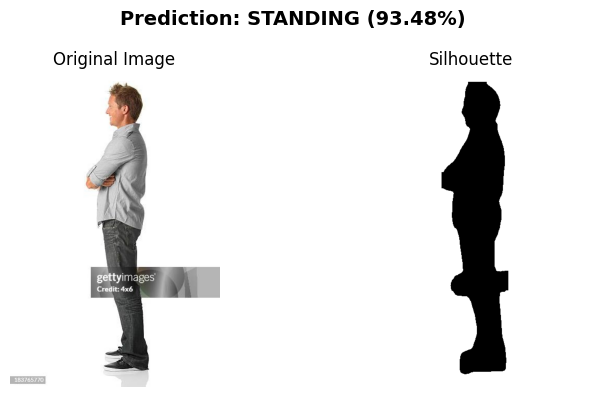

../../images/human_standing.jpg {'predicted_class': 'standing', 'confidence': 0.9348427057266235, 'prob_sitting': 0.06515730917453766, 'prob_standing': 0.9348427057266235}

0: 640x448 1 person, 6.4ms
Speed: 1.3ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


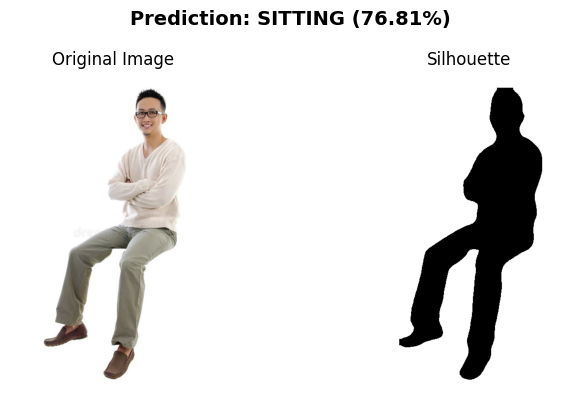

../../images/human_sitting.jpg {'predicted_class': 'sitting', 'confidence': 0.7680536508560181, 'prob_sitting': 0.7680536508560181, 'prob_standing': 0.2319464236497879}


In [42]:
model.load_state_dict(torch.load(WEIGHTS_DIR / FINETUNED_BEST_MODEL, map_location=DEVICE))
print("../../images/human_standing.jpg", predict_posture(
    "../../images/human_standing.jpg",
    model,
    device=DEVICE
))
print("../../images/human_sitting.jpg", predict_posture(
    "../../images/human_sitting.jpg",
    model,
    device=DEVICE
))

## Comparison

### Utility Functions

In [ ]:
def load_base_posture_model(num_classes=2, device="cpu"):
    # ImageNet-pretrained ResNet18
    model = models.resnet18(weights="IMAGENET1K_V1")

    # Replace classifier head
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    model.to(device)
    model.eval()   # IMPORTANT: no training

    return model

def load_posture_model(weights_path, num_classes=2, device="cpu"):
    model = models.resnet18(weights=None)  # or weights="IMAGENET1K_V1" if needed
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    state_dict = torch.load(weights_path, map_location=device)
    model.load_state_dict(state_dict)

    model.to(device)
    model.eval()
    return model

def compare_models_with_training(
    base_model,
    initial_model,
    finetuned_model,
    train_loader,
    val_loader,
    criterion,
    device,
    class_names=("sitting", "standing"),
    save_dir="results/confusion_matrices",
):
    models = {
        "Base": base_model,
        "Initial": initial_model,
        "Fine-tuned": finetuned_model,
    }

    results = {}

    # ---- Evaluate ----
    for name, model in models.items():
        results[name] = {
            "train": validate(model, train_loader, criterion, device),
            "val": validate(model, val_loader, criterion, device),
        }

    # ---- Print numeric summary ----
    print("Model Performance Comparison (Train vs Val)\n")
    header = f"{'Model':<12} {'Split':<6} {'Loss':>8} {'Acc':>8} {'Prec':>8} {'Rec':>8}"
    print(header)
    print("-" * len(header))

    for model_name, splits in results.items():
        for split in ["train", "val"]:
            m = splits[split]
            print(
                f"{model_name:<12} {split:<6} "
                f"{m['loss']:>8.4f} "
                f"{m['accuracy']:>8.4f} "
                f"{m['precision']:>8.4f} "
                f"{m['recall']:>8.4f}"
            )
        print("-" * len(header))

    # ---- Combined comparison plot (unchanged) ----
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

    for row, (model_name, splits) in enumerate(results.items()):
        for col, split in enumerate(["train", "val"]):
            cm = splits[split]["confusion_matrix"]

            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Blues" if split == "val" else "Greens",
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[row, col],
            )

            axes[row, col].set_title(f"{model_name} ({split})")
            axes[row, col].set_xlabel("Predicted")
            axes[row, col].set_ylabel("True")

    plt.tight_layout()
    plt.show()

    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    for model_name, splits in results.items():
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))

        for idx, split in enumerate(["train", "val"]):
            cm = splits[split]["confusion_matrix"]

            sns.heatmap(
                cm,
                annot=True,
                fmt="d",
                cmap="Greens" if split == "train" else "Blues",
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[idx],
            )

            axes[idx].set_title(f"{split.capitalize()} Confusion Matrix")
            axes[idx].set_xlabel("Predicted")
            axes[idx].set_ylabel("True")

        fig.suptitle(f"{model_name} Model", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.92])

        save_path = save_dir / f"{model_name.lower()}_cm.png"
        plt.savefig(save_path, dpi=200)
        plt.close()

        print(f"✅ Saved grouped CM for {model_name}: {save_path}")

    return results


### Comparing Initial Model vs Finetuned Model

Model Performance Comparison (Train vs Val)

Model        Split      Loss      Acc     Prec      Rec
-------------------------------------------------------
Base         train    0.6380   0.6406   0.6100   0.7372
Base         val      0.6293   0.6687   0.6724   0.7577
-------------------------------------------------------
Initial      train    0.2905   0.8786   0.8574   0.9021
Initial      val      0.2580   0.9000   0.9141   0.9000
-------------------------------------------------------
Fine-tuned   train    0.2518   0.9047   0.9083   0.8957
Fine-tuned   val      0.2320   0.9208   0.9476   0.9038
-------------------------------------------------------


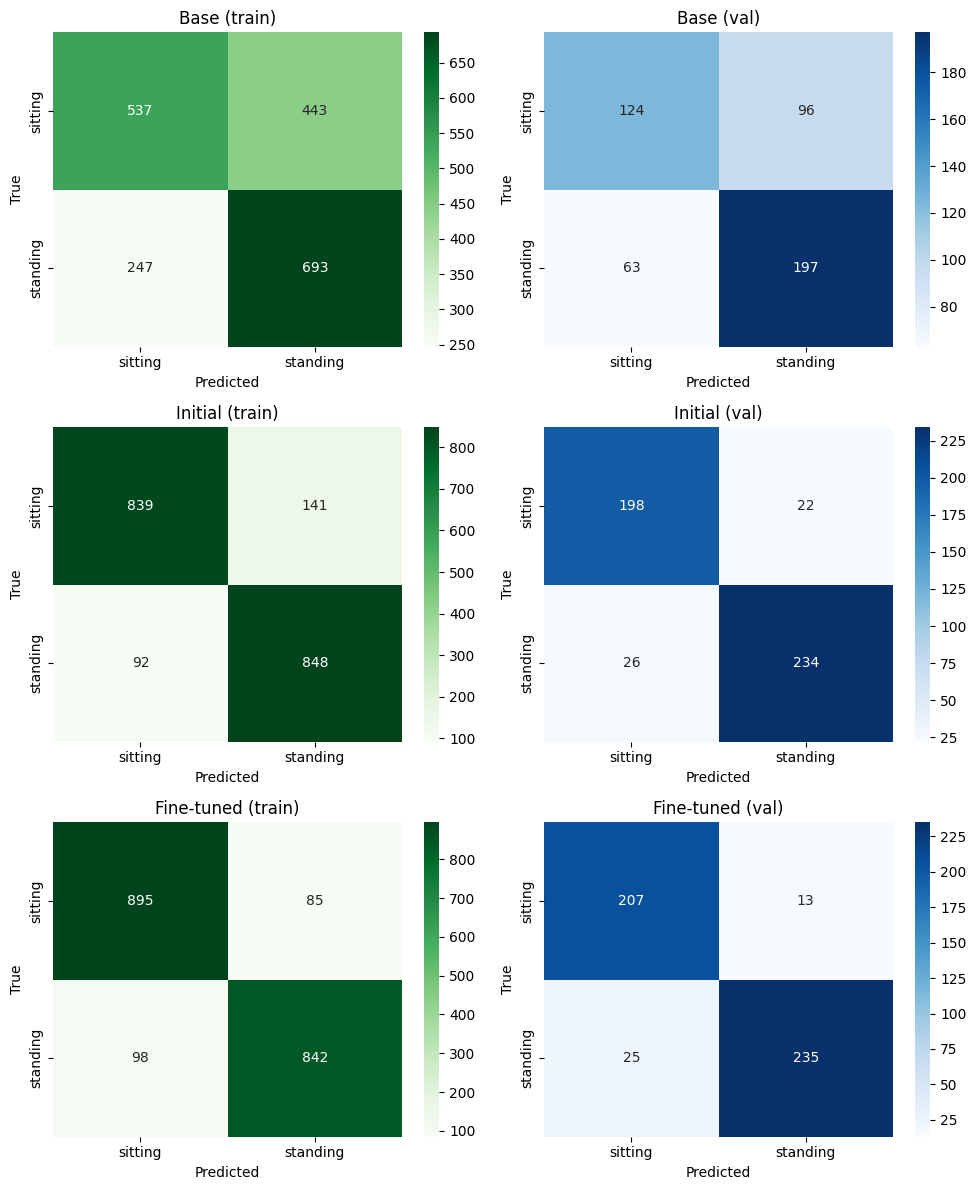

In [ ]:
base_model = base_model = load_base_posture_model(num_classes=2, device=DEVICE)
initial_model = load_posture_model(WEIGHTS_DIR / BEST_MODEL_NAME, num_classes=NUM_CLASSES, device=DEVICE)
finetuned_model = load_posture_model(WEIGHTS_DIR / FINETUNED_BEST_MODEL, num_classes=NUM_CLASSES, device=DEVICE)

compare_models_with_training(
    base_model,
    initial_model,
    finetuned_model,
    train_loader,
    val_loader,
    criterion,
    device=DEVICE,
    save_dir=WEIGHTS_DIR / "confusion_metrics"
)